In [1]:
import collections
from datetime import datetime
import gc
import logging
import os
import random
import sys


from matplotlib import pyplot as plt
import numpy as np
import optuna
from optuna import integration
import pandas as pd
import PIL
from PIL import ImageFilter
from PIL import Image
from scipy import ndimage, signal
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.applications import EfficientNetB7, InceptionV3, ResNet152V2, ResNet50, VGG16
from tensorflow.keras.constraints import max_norm
import tensorflow as tf

# The Problem

The problem is described in detail [here](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia). Given the image of a chest xray as a jpeg file, classify the subject as normal or having pneumonia.  Further, classify the type of pneumonia as bacterial or viral.

Three folders are provided with images of chest xrays: train, val, and test.  The train folder has 1341 normal xrays and 3875 xrays with pneumonia.  The val folder has 8 normal and 8 pneumonia.  The test folder has 234 normal and 390 pneumonia.  

# General Approach

For binary classification of normal vs pneumonia, this solution explores three main avenues: use of transfer learning (pretrained convnets), use of class weights to deal with imbalanced classes, and use of hyperparameter optimization. 

Further, 3-way classification of normal vs bacterial pneumonia vs viral pneumonia was performed. 

**Step 1 - Use of transfer learning**

No class weights were used for this step.  A baseline model was built with a stack of CONV2D and MaxPooling2D layers, without any pretrained convnet. Then, four different pretrained convnets were explored:
* VGG16
* ResNet50
* InceptionV3
* EfficientNetB7

See [reference](https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/) and [reference](https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/) for more information on transfer learning architectures. 

The classification accuracies obtained were as follows:  

| Model | Max Val Accuracy | Test Accuracy | 
|-------|------------------|---------------|
| Baseline | 100%          | 74.68%        |
| VGG16  | 87.5%           | 79.00%        |
| ResNet50 | 62.5%         | 79.49%        |
| InceptionV3 | 93.75%     | 79.65%        |
| EfficientNetB7 | 50.00%  | 62.50%        |

InceptionV3 provided the best improvement over the baseline model.  

**Step 2 - Use of class weights**

The same methodology and models as step 1 were applied, this time with class weights to account for imbalance in classes.  

The classification accuracies obtained were as follows:  

| Model | Max Val Accuracy | Test Accuracy | 
|-------|------------------|---------------|
| Baseline | 100%          | 84.46%        |
| VGG16  | 93.75%          | 90.54%        |
| ResNet50 | 81.25%        | 71.79%        |
| InceptionV3 | 100%       | 89.42%        |
| EfficientNetB7 | 50.00%  | 37.50%        |

VGG16 and InceptionV3 provided the best improvement over the baseline model.  Use of class weights improved the performance of the baseline, VGG16, and InceptionV3 models, by about 10% in each case. The best classification accuracies on the test dataset were ~90%.   

**Step 3 - Use of hyperparameter optimization**

Optuna was used for hyperparameter optimization.  InceptionV3 was used as the pretrained convnet.  Paramaters tuned using Optuna were: batch size, dropout, no of units of the dense layers, learning rate, and regularization for the dense layers. The same class weights as in step 2 were used.   

The Optuna-tuned model gave a classification accuracy of 87.98% which was not an improvement over the accuracy obtained using the InceptionV3-based model in step 2.  

**Step 4 - Classification of normal vs bacterial vs viral pneumonia**

Further, the classification of normal vs bacterial pneumonia vs viral pneumonia was explored.  Class weights were used, as was transfer learning.  The Optuna-tuned paramaters and model were used.  The accuracy results were found to be sensitive to class weights.  Ensembling models trained with different sets of class weights did not necessarily improve classification accuracy.  Classification accuracies ~80% were obtained for this step.      


# Solution 

In [2]:
def show_image(image_id=None, what='train', subfolder='NORMAL'):
    """Show a random or requested xray image."""
    if image_id is None:
        all_files = os.listdir(f'{what}/{subfolder}')
        img_file = random.sample(all_files, 1)[0]
        image_id, _ = os.path.splitext(img_file)
    
    img = PIL.Image.open(os.path.join(os.getcwd(), what, subfolder, f'{image_id}.jpeg'))
    img = img.resize((256, 256))
    img_np = np.array(img)
    label = subfolder
    return img, img_np, label, image_id

### Normal X-ray

IM-0115-0001


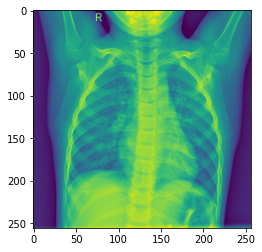

In [7]:
img, img_np, label, image_id = show_image(image_id='IM-0115-0001', what='train', subfolder='NORMAL')
_ = plt.imshow(img)
print(image_id)

### X-ray with bacterial pneumonia

person1_bacteria_2


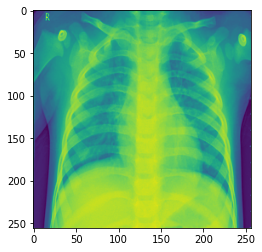

In [4]:
img, img_np, label, image_id = show_image(image_id='person1_bacteria_2', what='train', subfolder='PNEUMONIA')
_ = plt.imshow(img)
print(image_id)

### X-ray with viral pneumonia

person100_virus_184


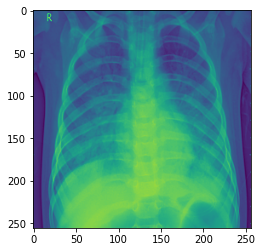

In [5]:
img, img_np, label, image_id = show_image(image_id='person100_virus_184', what='train', subfolder='PNEUMONIA')
_ = plt.imshow(img)
print(image_id)

# Use of Transfer Learning

In [3]:
def generate_x_and_y_inmemory(what='train', image_size=None, convert_to_bw=False):
    all_files_normal = [x for x in os.listdir(f'{what}/NORMAL') if x.endswith('jpeg')]
    all_files_pneumonia = [x for x in os.listdir(f'{what}/PNEUMONIA') if x.endswith('jpeg')]
    
    x = []
    y = [] 
    
    for file in all_files_normal:
        image_id, _ = os.path.splitext(file)
        img, img_np, label, image_id = show_image(image_id, what, subfolder='NORMAL')
        if image_size:
            img = img.resize(image_size)

        if convert_to_bw:
            img = img.convert('L')
            img_np = np.expand_dims(np.array(img) / 255., -1)
        else:
            img = img.convert('RGB')
            img_np = np.array(img) / 255.
            
        x.append(img_np)
        y.append(0.0)
        
    for file in all_files_pneumonia:
        image_id, _ = os.path.splitext(file)
        img, img_np, label, image_id = show_image(image_id, what, subfolder='PNEUMONIA')
        if image_size:
            img = img.resize(image_size)

        if convert_to_bw:
            img = img.convert('L')
            img_np = np.expand_dims(np.array(img) / 255., -1)
        else:
            img = img.convert('RGB')
            img_np = np.array(img) / 255.
            
        x.append(img_np)
        y.append(1.0)
    
    return np.array(x), np.array(y)

## Simple CNN without pretrained convnet, as baseline

In [10]:
xtrain, ytrain = generate_x_and_y_inmemory(what='train', image_size=(256, 256), convert_to_bw=True)
xval, yval = generate_x_and_y_inmemory(what='val', image_size=(256, 256), convert_to_bw=True)
xtest, ytest = generate_x_and_y_inmemory(what='test', image_size=(256, 256), convert_to_bw=True)

In [11]:
def build_model0():
    inp = keras.Input(shape=(256, 256, 1))
    x = keras.layers.Conv2D(9, (3, 3), activation='relu')(inp)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
    x = keras.layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    out = keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=inp, outputs=out)
    model.compile(
        loss=keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(1e-4),
        metrics=['accuracy'],
    )
    
    return model

In [12]:
model = build_model0()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 9)       90        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 9)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 16)      1312      
_________________________________________________________________
flatten (Flatten)            (None, 250000)            0         
_________________________________________________________________
dropout (Dropout)            (None, 250000)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                160000

In [13]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint('keya_model.h5', save_best_only=True, monitor='loss'),
]

history = model.fit(xtrain, ytrain,
                    callbacks=callbacks_list,
                    validation_data = (xval, yval),
                    verbose=1,
                    epochs=20,
                    batch_size=16,
                   )

gc.collect()

Epoch 1/20
326/326 [==============================] - 5s 8ms/step - loss: 0.3674 - accuracy: 0.8453 - val_loss: 0.4352 - val_accuracy: 0.8750
Epoch 2/20
326/326 [==============================] - 2s 7ms/step - loss: 0.1372 - accuracy: 0.9461 - val_loss: 0.3360 - val_accuracy: 0.8750
Epoch 3/20
326/326 [==============================] - 2s 7ms/step - loss: 0.0968 - accuracy: 0.9644 - val_loss: 0.5999 - val_accuracy: 0.6875
Epoch 4/20
326/326 [==============================] - 2s 7ms/step - loss: 0.0786 - accuracy: 0.9702 - val_loss: 0.1553 - val_accuracy: 0.9375
Epoch 5/20
326/326 [==============================] - 2s 7ms/step - loss: 0.0637 - accuracy: 0.9760 - val_loss: 0.5845 - val_accuracy: 0.6875
Epoch 6/20
326/326 [==============================] - 2s 7ms/step - loss: 0.0507 - accuracy: 0.9809 - val_loss: 0.3540 - val_accuracy: 0.8125
Epoch 7/20
326/326 [==============================] - 2s 7ms/step - loss: 0.0364 - accuracy: 0.9880 - val_loss: 0.1727 - val_accuracy: 0.8750
Epoch 

1911

Max Validation Accuracy:  1.0


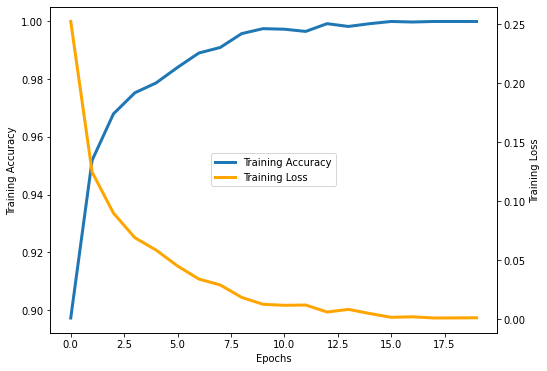

In [14]:
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

lns1 = ax1.plot(history.history['accuracy'], lw=3, label='Training Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Accuracy')

lns2 = ax2.plot(history.history['loss'], color='orange', lw=3, label='Training Loss')
ax2.set_ylabel('Training Loss')

leg = lns1 + lns2
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc='center')

print("Max Validation Accuracy: ", np.max(history.history['val_accuracy']))

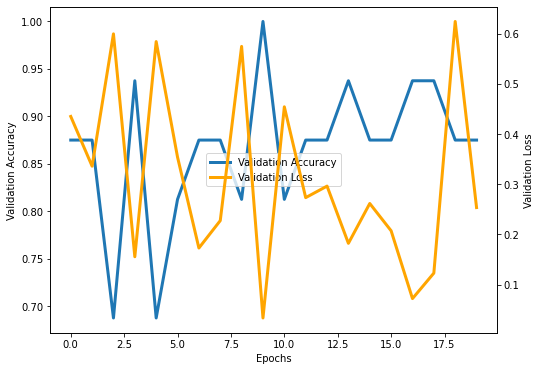

In [15]:
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

lns1 = ax1.plot(history.history['val_accuracy'], lw=3, label='Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Validation Accuracy')

lns2 = ax2.plot(history.history['val_loss'], color='orange', lw=3, label='Validation Loss')
ax2.set_ylabel('Validation Loss')

leg = lns1 + lns2
labs = [l.get_label() for l in leg]
_ = ax1.legend(leg, labs, loc='center')

### Inference

In [16]:
model = keras.models.load_model('keya_model.h5')

In [17]:
model.evaluate(xtest, ytest)

20/20 [==============================] - 0s 7ms/step - loss: 1.9814 - accuracy: 0.7468


[1.981381893157959, 0.7467948794364929]

## Transfer Learning

In [25]:
xtrain, ytrain = generate_x_and_y_inmemory(what='train', image_size=(150, 150), convert_to_bw=False)
xval, yval = generate_x_and_y_inmemory(what='val', image_size=(150, 150), convert_to_bw=False)
xtest, ytest = generate_x_and_y_inmemory(what='test', image_size=(150, 150), convert_to_bw=False)

In [19]:
dd_pretrained = {'VGG' : VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3)),
                 'ResNet' : ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3)),
                 'Inception' : InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3)),
                 'EfficientNet' : EfficientNetB7(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
                } 

258080768/258076736 [==============================] - 6s 0us/step


In [20]:


def build_model_transfer(conv_base):
    
    conv_base.trainable=False

    
    inp = keras.Input(shape=(150, 150, 3))
    x = conv_base(inp)
    x = keras.layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(32, kernel_constraint=max_norm(2.), kernel_regularizer=regularizers.l1(0.01), activation='relu')(x)
    
    x = layers.Dense(32, kernel_constraint=max_norm(2.), kernel_regularizer=regularizers.l1(0.01), activation='relu')(x)
    
    x = layers.Dense(32, kernel_constraint=max_norm(2.), kernel_regularizer=regularizers.l1(0.01), activation='relu')(x)
    
    out = keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=inp, outputs=out)
    model.compile(
        loss=keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(1e-4),
        metrics=['accuracy'],
    )
    
    return model

### VGG

In [26]:
model = build_model_transfer(dd_pretrained['VGG'])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                262176    
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                1056

In [27]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint('keya_model_transfer.h5', save_best_only=True, monitor='loss'),
]

history = model.fit(xtrain, ytrain,
                    callbacks=callbacks_list,
                    validation_data=(xval, yval),
                    verbose=0,
                    epochs=40,
                    batch_size=16,
                   )

Max Validation Accuracy:  0.875


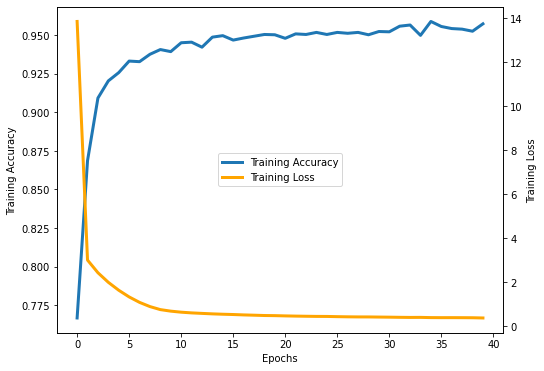

In [28]:
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

lns1 = ax1.plot(history.history['accuracy'], lw=3, label='Training Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Accuracy')

lns2 = ax2.plot(history.history['loss'], color='orange', lw=3, label='Training Loss')
ax2.set_ylabel('Training Loss')

leg = lns1 + lns2
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc='center')

print("Max Validation Accuracy: ", np.max(history.history['val_accuracy']))

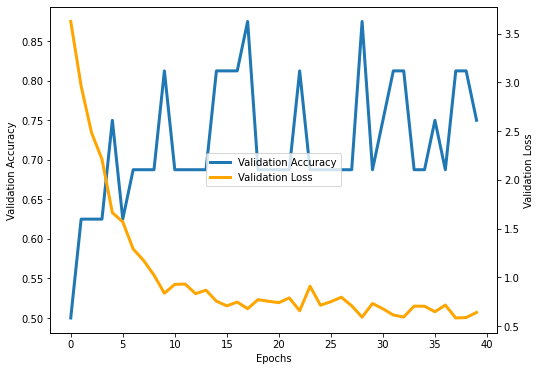

In [29]:
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

lns1 = ax1.plot(history.history['val_accuracy'], lw=3, label='Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Validation Accuracy')

lns2 = ax2.plot(history.history['val_loss'], color='orange', lw=3, label='Validation Loss')
ax2.set_ylabel('Validation Loss')

leg = lns1 + lns2
labs = [l.get_label() for l in leg]
_ = ax1.legend(leg, labs, loc='center')

### Inference 

In [30]:
model = keras.models.load_model('keya_model_transfer.h5')

In [31]:
model.evaluate(xtest, ytest)

20/20 [==============================] - 1s 32ms/step - loss: 0.6911 - accuracy: 0.7901


[0.691062867641449, 0.7900640964508057]

## ResNet 

In [38]:
model = build_model_transfer(dd_pretrained['ResNet'])
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_4 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 51200)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                1638432   
_________________________________________________________________
dense_16 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_17 (Dense)             (None, 32)                1056

In [39]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint('keya_model_transfer.h5', save_best_only=True, monitor='loss'),
]


history = model.fit(xtrain, ytrain,
                    callbacks=callbacks_list,
                    validation_data=(xval, yval),
                    verbose=0,
                    epochs=80,
                    batch_size=16,
                   )

Max Validation Accuracy:  0.625


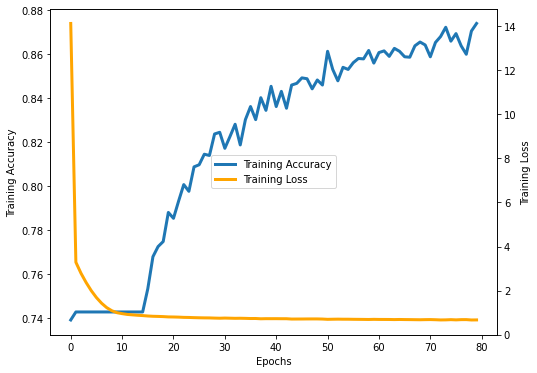

In [40]:
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

lns1 = ax1.plot(history.history['accuracy'], lw=3, label='Training Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Accuracy')

lns2 = ax2.plot(history.history['loss'], color='orange', lw=3, label='Training Loss')
ax2.set_ylabel('Training Loss')

leg = lns1 + lns2
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc='center')

print("Max Validation Accuracy: ", np.max(history.history['val_accuracy']))

### Inference 

In [41]:
model = keras.models.load_model('keya_model_transfer.h5')

In [42]:
model.evaluate(xtest, ytest)

20/20 [==============================] - 1s 25ms/step - loss: 0.7794 - accuracy: 0.7949


[0.7793697714805603, 0.7948718070983887]

## Inception

In [43]:
model = build_model_transfer(dd_pretrained['Inception'])
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_5 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 18432)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                589856    
_________________________________________________________________
dense_20 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_21 (Dense)             (None, 32)                1056

In [44]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint('keya_model_transfer.h5', save_best_only=True, monitor='loss'),
]

history = model.fit(xtrain, ytrain,
                    callbacks=callbacks_list,
                    validation_data=(xval, yval),
                    verbose=0,
                    epochs=40,
                    batch_size=16,
                   )

Max Validation Accuracy:  0.9375


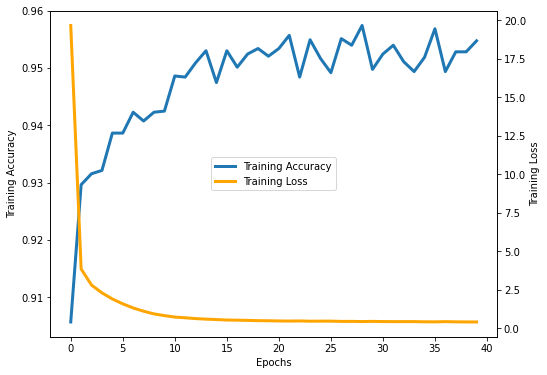

In [45]:
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

lns1 = ax1.plot(history.history['accuracy'], lw=3, label='Training Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Accuracy')

lns2 = ax2.plot(history.history['loss'], color='orange', lw=3, label='Training Loss')
ax2.set_ylabel('Training Loss')

leg = lns1 + lns2
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc='center')

print("Max Validation Accuracy: ", np.max(history.history['val_accuracy']))

### Inference

In [46]:
model = keras.models.load_model('keya_model_transfer.h5')

In [47]:
model.evaluate(xtest, ytest)

20/20 [==============================] - 1s 17ms/step - loss: 0.7824 - accuracy: 0.7965


[0.7823675870895386, 0.7964743375778198]

## EfficientNet

In [48]:
model = build_model_transfer(dd_pretrained['EfficientNet'])
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, 5, 5, 2560)        64097687  
_________________________________________________________________
flatten_6 (Flatten)          (None, 64000)             0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 64000)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 32)                2048032   
_________________________________________________________________
dense_24 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_25 (Dense)             (None, 32)                1056

In [49]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint('keya_model_transfer.h5', save_best_only=True, monitor='loss'),
]


history = model.fit(xtrain, ytrain,
                    callbacks=callbacks_list,
                    validation_data=(xval, yval),
                    verbose=0,
                    epochs=40,
                    batch_size=16,
                   )

Max Validation Accuracy:  0.5


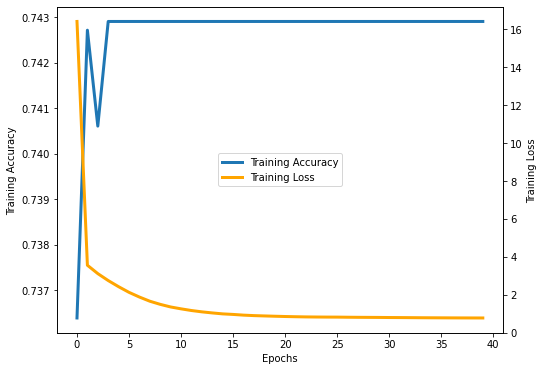

In [50]:
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

lns1 = ax1.plot(history.history['accuracy'], lw=3, label='Training Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Accuracy')

lns2 = ax2.plot(history.history['loss'], color='orange', lw=3, label='Training Loss')
ax2.set_ylabel('Training Loss')

leg = lns1 + lns2
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc='center')

print("Max Validation Accuracy: ", np.max(history.history['val_accuracy']))

### Inference

In [51]:
model = keras.models.load_model('keya_model_transfer.h5')

In [52]:
model.evaluate(xtest, ytest)

20/20 [==============================] - 5s 102ms/step - loss: 0.9036 - accuracy: 0.6250


[0.9035763144493103, 0.625]

# Use of Class Weights 

## Simple CNN without pretrained convnet 

In [4]:
xtrain, ytrain = generate_x_and_y_inmemory(what='train', image_size=(256, 256), convert_to_bw=True)
xval, yval = generate_x_and_y_inmemory(what='val', image_size=(256, 256), convert_to_bw=True)
xtest, ytest = generate_x_and_y_inmemory(what='test', image_size=(256, 256), convert_to_bw=True)

In [5]:
dd = collections.Counter(ytrain)
print(dd)

Counter({1.0: 3875, 0.0: 1341})


In [6]:
def build_model0():
    inp = keras.Input(shape=(256, 256, 1))
    x = keras.layers.Conv2D(9, (3, 3), activation='relu')(inp)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
    x = keras.layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    out = keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=inp, outputs=out)
    model.compile(
        loss=keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(1e-4),
        metrics=['accuracy'],
    )
    
    return model

In [7]:
model = build_model0()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 9)       90        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 9)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 16)      1312      
_________________________________________________________________
flatten (Flatten)            (None, 250000)            0         
_________________________________________________________________
dropout (Dropout)            (None, 250000)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                160000

In [8]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint('keya_model.h5', save_best_only=True, monitor='loss'),
]

class_wts = {0.0: 100,
             1.0: 1}

history = model.fit(xtrain, ytrain,
                    callbacks=callbacks_list,
                    validation_data = (xval, yval),
                    verbose=0,
                    epochs=20,
                    batch_size=16,
                    class_weight=class_wts,
                   )

gc.collect()

2022

Max Validation Accuracy:  1.0


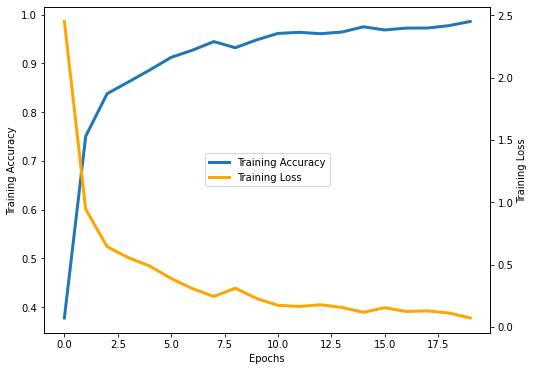

In [9]:
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

lns1 = ax1.plot(history.history['accuracy'], lw=3, label='Training Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Accuracy')

lns2 = ax2.plot(history.history['loss'], color='orange', lw=3, label='Training Loss')
ax2.set_ylabel('Training Loss')

leg = lns1 + lns2
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc='center')

print("Max Validation Accuracy: ", np.max(history.history['val_accuracy']))

### Inference

In [10]:
model = keras.models.load_model('keya_model.h5')

In [11]:
model.evaluate(xtest, ytest)

20/20 [==============================] - 0s 7ms/step - loss: 0.7793 - accuracy: 0.8446


[0.7793493270874023, 0.8445512652397156]

## Transfer Learning

In [12]:
xtrain, ytrain = generate_x_and_y_inmemory(what='train', image_size=(150, 150), convert_to_bw=False)
xval, yval = generate_x_and_y_inmemory(what='val', image_size=(150, 150), convert_to_bw=False)
xtest, ytest = generate_x_and_y_inmemory(what='test', image_size=(150, 150), convert_to_bw=False)

In [13]:
dd_pretrained = {'VGG' : VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3)),
                 'ResNet' : ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3)),
                 'Inception' : InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3)),
                 'EfficientNet' : EfficientNetB7(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
                } 

In [14]:

def build_model_transfer(conv_base):
    
    conv_base.trainable=False

    
    inp = keras.Input(shape=(150, 150, 3))
    x = conv_base(inp)
    x = keras.layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(32, kernel_constraint=max_norm(2.), kernel_regularizer=regularizers.l1(0.01), activation='relu')(x)
    
    
    x = layers.Dense(32, kernel_constraint=max_norm(2.), kernel_regularizer=regularizers.l1(0.01), activation='relu')(x)
    
    
    x = layers.Dense(32, kernel_constraint=max_norm(2.), kernel_regularizer=regularizers.l1(0.01), activation='relu')(x)
    
    out = keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=inp, outputs=out)
    model.compile(
        loss=keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(1e-4),
        metrics=['accuracy'],
    )
    
    return model

### VGG

In [15]:
model = build_model_transfer(dd_pretrained['VGG'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                262176    
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056

In [16]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint('keya_model_transfer.h5', save_best_only=True, monitor='loss'),
]

class_wts = {0.0: 100, 
             1.0: 1}

history = model.fit(xtrain, ytrain,
                    callbacks=callbacks_list,
                    validation_data=(xval, yval),
                    verbose=0,
                    epochs=40,
                    class_weight=class_wts,
                    batch_size=16,
                   )

gc.collect()

5921

Max Validation Accuracy:  0.9375


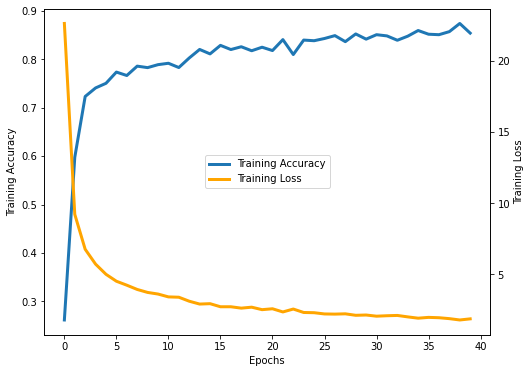

In [17]:
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

lns1 = ax1.plot(history.history['accuracy'], lw=3, label='Training Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Accuracy')

lns2 = ax2.plot(history.history['loss'], color='orange', lw=3, label='Training Loss')
ax2.set_ylabel('Training Loss')

leg = lns1 + lns2
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc='center')

print("Max Validation Accuracy: ", np.max(history.history['val_accuracy']))

### Inference 

In [18]:
model = keras.models.load_model('keya_model_transfer.h5')

In [19]:
model.evaluate(xtest, ytest)

20/20 [==============================] - 1s 32ms/step - loss: 1.4784 - accuracy: 0.9054


[1.4784059524536133, 0.9054487347602844]

## ResNet 

In [20]:
model = build_model_transfer(dd_pretrained['ResNet'])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 51200)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1638432   
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                1056

In [21]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint('keya_model_transfer.h5', save_best_only=True, monitor='loss'),
]

class_wts = {0.0: 100, 
             1.0: 1}

history = model.fit(xtrain, ytrain,
                    callbacks=callbacks_list,
                    validation_data=(xval, yval),
                    verbose=0,
                    epochs=80,
                    class_weight=class_wts,
                    batch_size=16,
                   )

gc.collect()


2664

Max Validation Accuracy:  0.8125


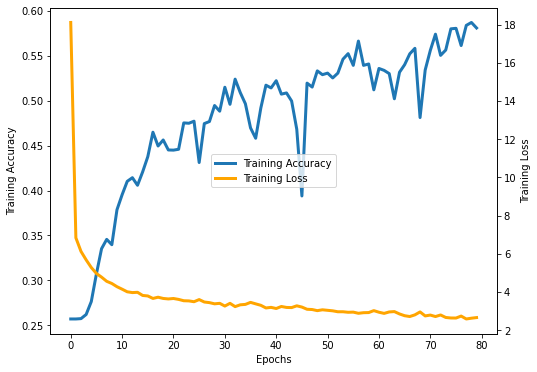

In [22]:
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

lns1 = ax1.plot(history.history['accuracy'], lw=3, label='Training Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Accuracy')

lns2 = ax2.plot(history.history['loss'], color='orange', lw=3, label='Training Loss')
ax2.set_ylabel('Training Loss')

leg = lns1 + lns2
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc='center')

print("Max Validation Accuracy: ", np.max(history.history['val_accuracy']))

### Inference 

In [23]:
model = keras.models.load_model('keya_model_transfer.h5')

In [24]:
model.evaluate(xtest, ytest)

20/20 [==============================] - 1s 24ms/step - loss: 1.6120 - accuracy: 0.7179


[1.612030267715454, 0.7179487347602844]

## Inception

In [25]:
model = build_model_transfer(dd_pretrained['Inception'])
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_3 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 18432)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                589856    
_________________________________________________________________
dense_12 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_13 (Dense)             (None, 32)                1056

In [26]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint('keya_model_transfer.h5', save_best_only=True, monitor='loss'),
]

class_wts = {0.0: 100, 
             1.0: 1}

history = model.fit(xtrain, ytrain,
                    callbacks=callbacks_list,
                    validation_data=(xval, yval),
                    verbose=0,
                    epochs=40,
                    class_weight=class_wts,
                    batch_size=16,
                   )

gc.collect()

3346

Max Validation Accuracy:  1.0


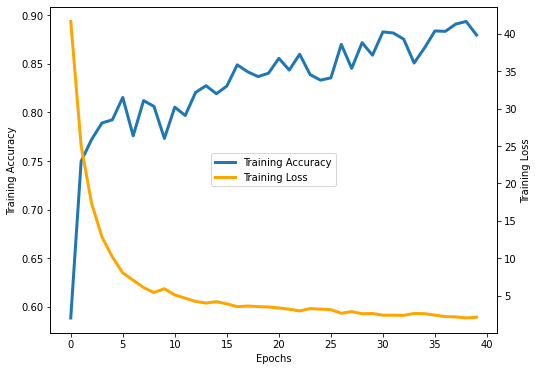

In [27]:
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

lns1 = ax1.plot(history.history['accuracy'], lw=3, label='Training Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Accuracy')

lns2 = ax2.plot(history.history['loss'], color='orange', lw=3, label='Training Loss')
ax2.set_ylabel('Training Loss')

leg = lns1 + lns2
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc='center')

print("Max Validation Accuracy: ", np.max(history.history['val_accuracy']))

### Inference

In [28]:
model = keras.models.load_model('keya_model_transfer.h5')

In [29]:
model.evaluate(xtest, ytest)

20/20 [==============================] - 2s 17ms/step - loss: 1.8725 - accuracy: 0.8942


[1.8724945783615112, 0.8942307829856873]

## EfficientNet

In [30]:
model = build_model_transfer(dd_pretrained['EfficientNet'])
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, 5, 5, 2560)        64097687  
_________________________________________________________________
flatten_4 (Flatten)          (None, 64000)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64000)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                2048032   
_________________________________________________________________
dense_16 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_17 (Dense)             (None, 32)                1056

In [31]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint('keya_model_transfer.h5', save_best_only=True, monitor='loss'),
]

class_wts = {0.0: 100, 
             1.0: 1}

history = model.fit(xtrain, ytrain,
                    callbacks=callbacks_list,
                    validation_data=(xval, yval),
                    verbose=0,
                    epochs=40,
                    class_weight=class_wts,
                    batch_size=16,
                   )

gc.collect()

3656

Max Validation Accuracy:  0.5


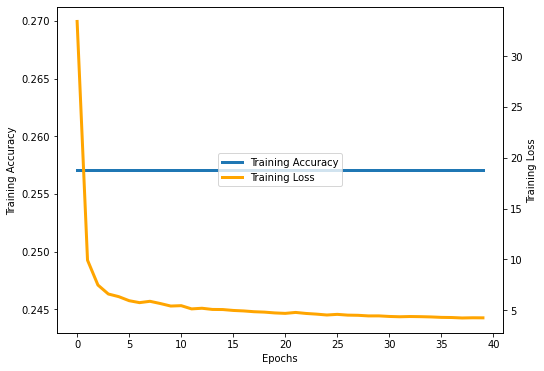

In [32]:
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

lns1 = ax1.plot(history.history['accuracy'], lw=3, label='Training Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Accuracy')

lns2 = ax2.plot(history.history['loss'], color='orange', lw=3, label='Training Loss')
ax2.set_ylabel('Training Loss')

leg = lns1 + lns2
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc='center')

print("Max Validation Accuracy: ", np.max(history.history['val_accuracy']))

### Inference

In [33]:
model = keras.models.load_model('keya_model_transfer.h5')

In [34]:
model.evaluate(xtest, ytest)

20/20 [==============================] - 5s 102ms/step - loss: 3.0230 - accuracy: 0.3750


[3.0230329036712646, 0.375]

# Optuna for Hyperparameter Tuning

In [7]:
IMAGE_SIZE = (150, 150)
ES_PATIENCE = 5
MAX_EPOCHS = 10

# Optuna hyperparameter search.
OP_BATCH_SIZES = [16, 128]
OP_DROPOUT_MIN = 0.
OP_DROPOUT_MAX = 1.
OP_UNITS = [32, 64, 128, 256, 512]
OP_LR_MIN = 1e-5
OP_LR_MAX = 1e-2
OP_REG_MIN = 1e-5
OP_REG_MAX = 1


def build_op_model(trial):
    conv_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    conv_base.trainable=False
    
    dropout = trial.suggest_float('dropout', OP_DROPOUT_MIN, OP_DROPOUT_MAX)
    units = trial.suggest_categorical("units", OP_UNITS)
    learning_rate = trial.suggest_float("lr", OP_LR_MIN, OP_LR_MAX, log=True)
    reg = trial.suggest_float("reg", OP_REG_MIN, OP_REG_MAX, log=True)
    
    inp = keras.Input(shape=(150, 150, 3))
    x = conv_base(inp)
    x = keras.layers.Flatten()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(units, kernel_constraint=max_norm(2.), kernel_regularizer=regularizers.l1(reg), activation='relu')(x)
    
    x = layers.Dense(units, kernel_constraint=max_norm(2.), kernel_regularizer=regularizers.l1(reg), activation='relu')(x)
       
    x = layers.Dense(units, kernel_constraint=max_norm(2.), kernel_regularizer=regularizers.l1(reg), activation='relu')(x)
    
    out = keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=inp, outputs=out)
    model.compile(
        loss=keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(learning_rate),
        metrics=['accuracy'],
    )
    
    return model


def objective(trial):
    
    batch_size = trial.suggest_categorical('batch_size', OP_BATCH_SIZES)
    
    model = build_op_model(trial)
    
    # Create callbacks for early stopping and pruning.
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=ES_PATIENCE),
    ]
    
    history = model.fit(
        xtrain, ytrain,
        callbacks=callbacks,
        validation_data=(xval, yval),
        verbose=False,
        epochs=MAX_EPOCHS,
        batch_size=batch_size,
    )
    gc.collect()
    
    return history.history['val_loss'][-1]
    

In [8]:
study = optuna.create_study(
    direction='minimize', 
)

study.optimize(objective, n_trials=100)

[I 2021-05-07 02:15:19,994] A new study created in memory with name: no-name-b1f8b79a-ba4f-4009-86a1-b8d934e976e2
[I 2021-05-07 02:15:51,757] Trial 0 finished with value: 56.20198440551758 and parameters: {'batch_size': 128, 'dropout': 0.05084181457371095, 'units': 256, 'lr': 1.4837803857482134e-05, 'reg': 0.0020133808647163623}. Best is trial 0 with value: 56.20198440551758.
[I 2021-05-07 02:16:19,180] Trial 1 finished with value: 2296.650390625 and parameters: {'batch_size': 128, 'dropout': 0.9049682559547294, 'units': 512, 'lr': 3.8366676585767424e-05, 'reg': 0.16546592491941778}. Best is trial 0 with value: 56.20198440551758.
[I 2021-05-07 02:16:46,356] Trial 2 finished with value: 0.37335434556007385 and parameters: {'batch_size': 128, 'dropout': 0.3195239432698459, 'units': 32, 'lr': 0.0014106540014888038, 'reg': 4.5795036679013116e-05}. Best is trial 2 with value: 0.37335434556007385.
[I 2021-05-07 02:17:14,225] Trial 3 finished with value: 3.8908445835113525 and parameters: {'b

In [9]:
study.trials_dataframe().sort_values('value').head(10)

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dropout,params_lr,params_reg,params_units,state
72,72,0.191867,2021-05-07 03:15:07.562201,2021-05-07 03:16:08.149815,0 days 00:01:00.587614,16,0.604984,0.000531,0.000010,64,COMPLETE
45,45,0.232468,2021-05-07 02:49:27.492818,2021-05-07 02:50:32.241066,0 days 00:01:04.748248,16,0.534231,0.000959,0.000010,64,COMPLETE
19,19,0.239050,2021-05-07 02:29:17.304448,2021-05-07 02:29:45.229643,0 days 00:00:27.925195,128,0.194748,0.000681,0.000010,32,COMPLETE
73,73,0.269000,2021-05-07 03:16:08.151180,2021-05-07 03:17:08.687586,0 days 00:01:00.536406,16,0.535750,0.000606,0.000017,64,COMPLETE
31,31,0.275321,2021-05-07 02:35:39.307863,2021-05-07 02:36:43.030199,0 days 00:01:03.722336,16,0.453027,0.000470,0.000012,32,COMPLETE
75,75,0.304974,2021-05-07 03:18:08.550493,2021-05-07 03:19:09.270901,0 days 00:01:00.720408,16,0.660640,0.001048,0.000014,64,COMPLETE
49,49,0.321270,2021-05-07 02:53:43.473608,2021-05-07 02:54:46.627065,0 days 00:01:03.153457,16,0.682507,0.000344,0.000042,64,COMPLETE
91,91,0.324194,2021-05-07 03:32:36.118572,2021-05-07 03:33:37.391383,0 days 00:01:01.272811,16,0.440654,0.000439,0.000011,32,COMPLETE
53,53,0.324268,2021-05-07 02:57:56.816941,2021-05-07 02:59:00.464785,0 days 00:01:03.647844,16,0.537786,0.000339,0.000028,64,COMPLETE
74,74,0.327748,2021-05-07 03:17:08.688966,2021-05-07 03:18:08.549074,0 days 00:00:59.860108,16,0.546097,0.001043,0.000014,64,COMPLETE


In [8]:

MAX_EPOCHS = 20


def build_op_model():
    conv_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    conv_base.trainable=False
    
    dropout = 0.604984
    units = 64
    learning_rate = 0.000531
    reg = 0.000010
    
    inp = keras.Input(shape=(150, 150, 3))
    x = conv_base(inp)
    x = keras.layers.Flatten()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(units, kernel_constraint=max_norm(2.), kernel_regularizer=regularizers.l1(reg), activation='relu')(x)
    
    x = layers.Dense(units, kernel_constraint=max_norm(2.), kernel_regularizer=regularizers.l1(reg), activation='relu')(x)
    
    x = layers.Dense(units, kernel_constraint=max_norm(2.), kernel_regularizer=regularizers.l1(reg), activation='relu')(x)
    out = keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=inp, outputs=out)
    model.compile(
        loss=keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(learning_rate),
        metrics=['accuracy'],
    )
    
    return model


batch_size = 16

model = build_op_model()

# Create callback for saving best model
callbacks = [
    keras.callbacks.ModelCheckpoint('keya_model_optuna.h5', save_best_only=True, monitor='loss')
    
]

class_wts = {0.0: 100, 
             1.0: 1}

history = model.fit(
    xtrain, ytrain,
    callbacks=callbacks,
    validation_data=(xval, yval),
    verbose=True,
    epochs=MAX_EPOCHS,
    class_weight=class_wts,
    batch_size=batch_size,
)
gc.collect()    

Epoch 1/20
326/326 [==============================] - 10s 21ms/step - loss: 3.9279 - accuracy: 0.6252 - val_loss: 1.9887 - val_accuracy: 0.6250
Epoch 2/20
326/326 [==============================] - 6s 18ms/step - loss: 1.3383 - accuracy: 0.7310 - val_loss: 0.6419 - val_accuracy: 0.7500
Epoch 3/20
326/326 [==============================] - 6s 19ms/step - loss: 1.0332 - accuracy: 0.7955 - val_loss: 0.3330 - val_accuracy: 1.0000
Epoch 4/20
326/326 [==============================] - 6s 18ms/step - loss: 1.2729 - accuracy: 0.7602 - val_loss: 1.0720 - val_accuracy: 0.6875
Epoch 5/20
326/326 [==============================] - 6s 18ms/step - loss: 1.0554 - accuracy: 0.7724 - val_loss: 0.9870 - val_accuracy: 0.6875
Epoch 6/20
326/326 [==============================] - 6s 18ms/step - loss: 1.0700 - accuracy: 0.7867 - val_loss: 0.5505 - val_accuracy: 0.7500
Epoch 7/20
326/326 [==============================] - 6s 18ms/step - loss: 1.0611 - accuracy: 0.7784 - val_loss: 0.8365 - val_accuracy: 0.687

32844

In [9]:
model = keras.models.load_model('keya_model_optuna.h5')

In [10]:
model.evaluate(xtest, ytest)

20/20 [==============================] - 1s 19ms/step - loss: 0.4271 - accuracy: 0.8798


[0.42712241411209106, 0.879807710647583]

# Separately classifying bacterial vs viral pneumonia

In [6]:
def generate_x_and_y_inmemory_bac_vir(what='train', image_size=None, convert_to_bw=False):
    all_files_normal = [x for x in os.listdir(f'{what}/NORMAL') if x.endswith('jpeg')]
    all_files_pneumonia = [x for x in os.listdir(f'{what}/PNEUMONIA') if x.endswith('jpeg')]
    
    x = []
    y = [] 
    
    for file in all_files_normal:
        image_id, _ = os.path.splitext(file)
        img, img_np, label, image_id = show_image(image_id, what, subfolder='NORMAL')
        if image_size:
            img = img.resize(image_size)

        if convert_to_bw:
            img = img.convert('L')
            img_np = np.expand_dims(np.array(img) / 255., -1)
        else:
            img = img.convert('RGB')
            img_np = np.array(img) / 255.
            
        x.append(img_np)
        y.append(0.0)
        
    for file in all_files_pneumonia:
        image_id, _ = os.path.splitext(file)
        img, img_np, label, image_id = show_image(image_id, what, subfolder='PNEUMONIA')
        if image_size:
            img = img.resize(image_size)

        if convert_to_bw:
            img = img.convert('L')
            img_np = np.expand_dims(np.array(img) / 255., -1)
        else:
            img = img.convert('RGB')
            img_np = np.array(img) / 255.
            
        x.append(img_np)
        if 'virus' in image_id.split('_'):
            y.append(1.0)
        else: 
            y.append(2.0)
    
    return np.array(x), np.array(y)

In [4]:
xtrain, ytrain = generate_x_and_y_inmemory_bac_vir(what='train', image_size=(150, 150), convert_to_bw=False)
xval, yval = generate_x_and_y_inmemory_bac_vir(what='val', image_size=(150, 150), convert_to_bw=False)
xtest, ytest = generate_x_and_y_inmemory_bac_vir(what='test', image_size=(150, 150), convert_to_bw=False)

In [5]:
dd = collections.Counter(ytrain)
print(dd)

Counter({2.0: 2530, 1.0: 1345, 0.0: 1341})


In [6]:
def build_op_model_bac_vir():
    conv_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    conv_base.trainable = False
    
    dropout = 0.604984
    units = 64
    learning_rate = 0.000531
    reg = 0.000010
    
    inp = keras.Input(shape=(150, 150, 3))
    x = conv_base(inp)
    x = keras.layers.Flatten()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(units, kernel_constraint=max_norm(2.), kernel_regularizer=regularizers.l1(reg), activation='relu')(x)
    x = layers.Dense(units, kernel_constraint=max_norm(2.), kernel_regularizer=regularizers.l1(reg), activation='relu')(x)
    x = layers.Dense(units, kernel_constraint=max_norm(2.), kernel_regularizer=regularizers.l1(reg), activation='relu')(x)
    out = keras.layers.Dense(3, activation='softmax')(x)
    
    model = keras.Model(inputs=inp, outputs=out)
    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(),
        optimizer=keras.optimizers.Adam(learning_rate),
        metrics=['accuracy'],
    )
    
    return model

## Model 1 with first set of class weights

In [164]:
batch_size = 16
MAX_EPOCHS = 20
model = build_op_model_bac_vir()

# Create callbacks 
callbacks = [
    keras.callbacks.ModelCheckpoint('keya_model_bac_vir1.h5', save_best_only=True, monitor='loss')
]

class_wts = {0.0: 10,
             1.0: 5,
             2.0: 2}

history = model.fit(
    xtrain, ytrain,
    callbacks=callbacks,
    verbose=True,
    class_weight=class_wts,
    epochs=MAX_EPOCHS,
    batch_size=batch_size,
)
gc.collect()    

Epoch 1/20
326/326 [==============================] - 9s 18ms/step - loss: 3.5744 - accuracy: 0.5948
Epoch 2/20
326/326 [==============================] - 6s 18ms/step - loss: 2.1583 - accuracy: 0.7012
Epoch 3/20
326/326 [==============================] - 6s 18ms/step - loss: 2.1376 - accuracy: 0.7172
Epoch 4/20
326/326 [==============================] - 6s 18ms/step - loss: 1.9083 - accuracy: 0.7349
Epoch 5/20
326/326 [==============================] - 6s 18ms/step - loss: 1.7898 - accuracy: 0.7687
Epoch 6/20
326/326 [==============================] - 6s 18ms/step - loss: 1.9147 - accuracy: 0.7194
Epoch 7/20
326/326 [==============================] - 6s 18ms/step - loss: 1.7705 - accuracy: 0.7525
Epoch 8/20
326/326 [==============================] - 6s 18ms/step - loss: 1.7316 - accuracy: 0.7547
Epoch 9/20
326/326 [==============================] - 6s 18ms/step - loss: 1.7223 - accuracy: 0.7599
Epoch 10/20
326/326 [==============================] - 6s 18ms/step - loss: 1.7415 - accura

31603

In [7]:
model1 = keras.models.load_model('keya_model_bac_vir1.h5')

In [8]:
model1.evaluate(xtest, ytest)

20/20 [==============================] - 5s 53ms/step - loss: 0.7296 - accuracy: 0.8045


[0.7295964360237122, 0.8044871687889099]

In [9]:
y_one_hot1 = model1.predict(xtest)
y_pred1 = np.argmax(y_one_hot1, axis=1)

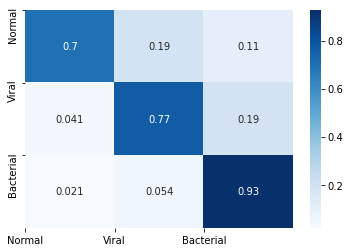

In [10]:
dd_labels = {0: 'Normal', 1: 'Viral', 2: 'Bacterial'}

cm = confusion_matrix(ytest, y_pred1, normalize='true')
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, cmap='Blues')
ax.set_xticks([0, 1, 2])
_ = ax.set_xticklabels(['Normal', 'Viral', 'Bacterial'])
ax.set_yticks([0, 1, 2])
_ = ax.set_yticklabels(['Normal', 'Viral', 'Bacterial'])

## Model 2 with second set of class weights

In [85]:
batch_size = 16
MAX_EPOCHS = 20
model = build_op_model_bac_vir()

# Create callbacks 
callbacks = [
    keras.callbacks.ModelCheckpoint('keya_model_bac_vir2.h5', save_best_only=True, monitor='loss')
]

class_wts = {0.0: 5,
             1.0: 1,
             2.0: 1}

history = model.fit(
    xtrain, ytrain,
    callbacks=callbacks,
    #validation_data=(xval, yval),
    verbose=True,
    class_weight=class_wts,
    epochs=MAX_EPOCHS,
    batch_size=batch_size,
)
gc.collect()   

Epoch 1/20
326/326 [==============================] - 9s 18ms/step - loss: 1.3362 - accuracy: 0.6504
Epoch 2/20
326/326 [==============================] - 6s 18ms/step - loss: 0.7283 - accuracy: 0.7686
Epoch 3/20
326/326 [==============================] - 6s 18ms/step - loss: 0.6783 - accuracy: 0.7767
Epoch 4/20
326/326 [==============================] - 6s 18ms/step - loss: 0.6233 - accuracy: 0.7964
Epoch 5/20
326/326 [==============================] - 6s 18ms/step - loss: 0.6208 - accuracy: 0.7923
Epoch 6/20
326/326 [==============================] - 6s 18ms/step - loss: 0.6305 - accuracy: 0.7890
Epoch 7/20
326/326 [==============================] - 6s 18ms/step - loss: 0.6102 - accuracy: 0.7940
Epoch 8/20
326/326 [==============================] - 6s 18ms/step - loss: 0.6259 - accuracy: 0.7932
Epoch 9/20
326/326 [==============================] - 6s 18ms/step - loss: 0.5907 - accuracy: 0.8041
Epoch 10/20
326/326 [==============================] - 6s 18ms/step - loss: 0.6339 - accura

31595

In [11]:
model2 = keras.models.load_model('keya_model_bac_vir2.h5')

In [12]:
model2.evaluate(xtest, ytest)

20/20 [==============================] - 1s 20ms/step - loss: 0.6396 - accuracy: 0.8365


[0.6395612955093384, 0.8365384340286255]

In [13]:
y_one_hot2 = model2.predict(xtest)
y_pred2 = np.argmax(y_one_hot2, axis=1)

Accuracy =  0.8365384615384616


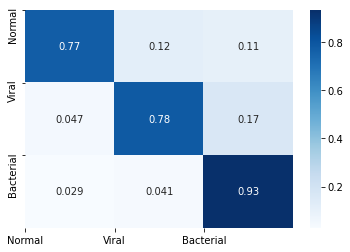

In [14]:
cm = confusion_matrix(ytest, y_pred2, normalize='true')
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, cmap='Blues')
ax.set_xticks([0, 1, 2])
_ = ax.set_xticklabels(['Normal', 'Viral', 'Bacterial'])
ax.set_yticks([0, 1, 2])
_ = ax.set_yticklabels(['Normal', 'Viral', 'Bacterial'])

accuracy = accuracy_score(ytest, y_pred2)
print("Accuracy = ", accuracy)

## Ensembling Model 1 and Model 2

In [ ]:
y_one_hot_ensemble = ([1, 1, 1] * y_one_hot1 + [1, 1, 1] * y_one_hot2) / 2

Accuracy =  0.8269230769230769


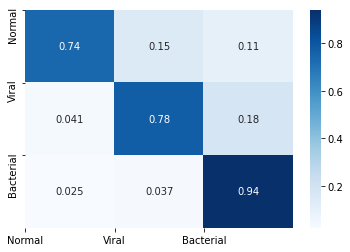

In [171]:
y_pred_ensemble = np.argmax(y_one_hot_ensemble, axis=1)

cm = confusion_matrix(ytest, y_pred_ensemble, normalize='true')
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, cmap='Blues')
ax.set_xticks([0, 1, 2])
_ = ax.set_xticklabels(['Normal', 'Viral', 'Bacterial'])
ax.set_yticks([0, 1, 2])
_ = ax.set_yticklabels(['Normal', 'Viral', 'Bacterial'])

accuracy = accuracy_score(ytest, y_pred_ensemble)
print("Accuracy = ", accuracy)